In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Step 1. Library and Dataset Loading

## Import Library

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os

print("Numpy ver.", np.__version__)
print("Pandas ver.", pd.__version__)
print("Matplotlib ver.", matplotlib.__version__)
print("Seaborn ver.", sns.__version__)

print(os.listdir('../input/spaceship-titanic/'))

Numpy ver. 1.20.3
Pandas ver. 1.3.5
Matplotlib ver. 3.5.1
Seaborn ver. 0.11.2
['sample_submission.csv', 'train.csv', 'test.csv']


In [3]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier

import time
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [4]:
BASE_DIR = '../input/spaceship-titanic/'
train = pd.read_csv(BASE_DIR + "train.csv")
test = pd.read_csv(BASE_DIR + "test.csv")
sample_submission = pd.read_csv(BASE_DIR + "sample_submission.csv")
print("Train Data:",train.shape)
print("Test Data:",test.shape)
print("Submission:",sample_submission.shape)

Train Data: (8693, 14)
Test Data: (4277, 13)
Submission: (4277, 2)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [7]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [8]:
test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


In [9]:
sample_submission.head(3)

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False


#### There are a total of 13 features, of which 6 are numerical variables.<br/>The target, the column we're going to predict, is 'Trasnported', which is a bool type variable

- For the detail descriptions, go to https://www.kaggle.com/competitions/spaceship-titanic/data

# Step 2. EDA

## Overview of Data

In [10]:
train.describe().T.style.background_gradient(cmap="Blues", axis=None,
                          vmin=0, vmax=100, high=0.5, text_color_threshold=0)\
                    .bar(subset=["count"], color="lavender", vmin=8000, vmax=8600)\
                    .bar(subset=["mean"], color="wheat", vmin=0)\
                    .bar(subset=["std"], color="peachpuff", vmin=0)\
                    .bar(subset=["max"], color="steelblue", vmin=0)

,count,mean,std,min,25%,50%,75%,max
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000


#### Except Age, more than half of each numeric variable is zero.
   - They are amount the passenger has billed at each of many amenities
   - Preprocessing such as feature engineering and one-hot encoding is required.

In [11]:
train.describe(include=['O']).T.style.background_gradient()\
                    .bar(subset=["count"], color="lavender", vmin=8000, vmax=8600)\
                    .bar(subset=["unique"], color="sandybrown")

,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Gollux Reedall,2


#### PassengerID, Cabin, and Name are text data, not categorical.
  - They don't seem to be important to the performance of the model.
  - In ML modeling, these features won't be used.

## Missing Value Distribution

In [12]:
train_miss = pd.DataFrame({'dtype' : train.iloc[:, :-1].dtypes,
                           'missing' : train.iloc[:, :-1].isnull().sum()})
test_miss = pd.DataFrame({'dtype' : test.dtypes,
                          'missing' : test.isnull().sum()})

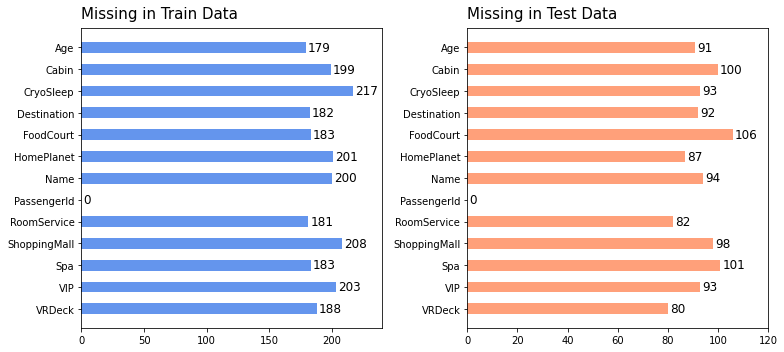

In [13]:
fig, ax = plt.subplots(1,2, figsize=(11,5))
width = 0.5
bar1 = ax[0].barh(sorted(train.columns[:-1].to_list(), reverse=True),
                  train_miss['missing'].sort_index(ascending=False),
                  width, color="cornflowerblue")
bar2 = ax[1].barh(sorted(test.columns.to_list(), reverse=True),
                  test_miss['missing'].sort_index(ascending=False),
                  width, color="lightsalmon")

ax[0].set_title("Missing in Train Data", loc="left", pad=10, size=15)
ax[0].set_xlim(0,240)
ax[1].set_title("Missing in Test Data", loc="left", pad=10, size=15)
ax[1].set_xlim(0,120)

ax[0].bar_label(bar1, padding=2, size=12)
ax[1].bar_label(bar2, padding=2, size=12)

fig.tight_layout()
plt.show()

#### The ratio of missing values by feature is less than 10%.
- The numerical features will be replaced by the median value.
- The categorical features will be replaced by the most frequent value.

## Categorical Feature Distribution

In [14]:
train_cat = train.select_dtypes(include = 'object')
test_cat = test.select_dtypes(include = 'object')
col_cat = train_cat.columns.to_list()[1:6]
del col_cat[2]
col_cat

['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

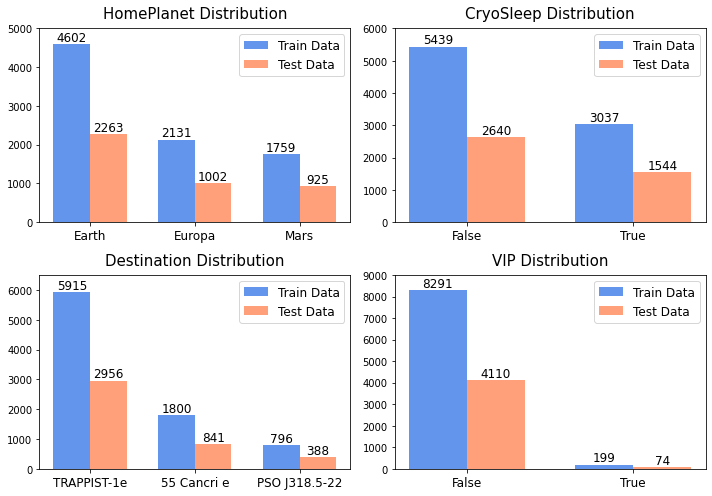

In [15]:
fig, ax = plt.subplots(2,2,figsize=(10,7))

width = 0.35
x = []
b = []
b2 = []

for i in range(2):
    for j in range(2):
        x.append(train_cat.loc[:,col_cat[2*i+j]].value_counts().index)
        b.append(ax[i,j].bar(np.arange(len(x[2*i+j])) - width/2,
                            train_cat.loc[:,col_cat[2*i+j]].value_counts().to_list(),
                            width, label = "Train Data", color="cornflowerblue"))
        b2.append(ax[i,j].bar(np.arange(len(x[2*i+j])) + width/2,
                            test_cat.loc[:,col_cat[2*i+j]].value_counts().to_list(),
                            width, label = "Test Data", color="lightsalmon"))
        ax[i,j].bar_label(b[2*i+j], label_type='edge', size=12)
        ax[i,j].bar_label(b2[2*i+j], label_type='edge', size=12)
        ax[i,j].set_title(f'{col_cat[2*i+j]} Distribution',
                          pad=10, size=15)
        ax[i,j].set_xticks(np.arange(len(x[2*i+j])), x[2*i+j], size=12)
        ax[i,j].legend(loc="best", fontsize=12)

ax[0,0].set_ylim(0,5000)
ax[0,1].set_ylim(0,6000)
ax[1,0].set_ylim(0,6500)
ax[1,1].set_ylim(0,9000)
        
fig.tight_layout()
plt.show()

#### The distribution in the training set and the test set is similar.
**HomePlanet**<br/>3 categories. - 'Earth' account for more than half.

**CryoSleep**<br/>False / True. - False is nearly twice as many as True.

**Destination**<br/>3 categories. - 'TRAPPIST-1e' accounts for about 70 percent.

**VIP**<br/>False / True. - False accounts for almost all data

## Numeric Feature Distribution

In [16]:
numeric = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
train_num = train.select_dtypes(include = numeric)
test_num = test.select_dtypes(include = numeric)
col_num = train_num.columns.to_list()
col_num

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

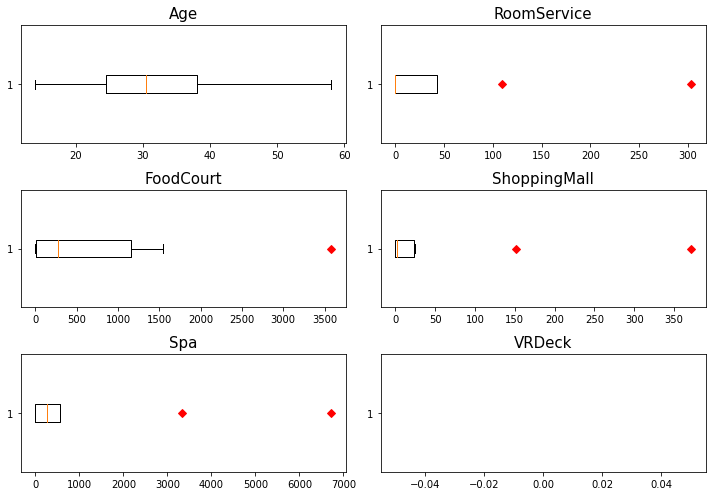

In [17]:
fig, ax = plt.subplots(3,2,figsize=(10,7))

for i in range(3):
    for j in range(2):
        ax[i, j].boxplot(train_num.iloc[:,2*i+j].tolist()[:10], 0, 'rD', vert=0)
        ax[i, j].set_title(col_num[2*i+j], pad=7, size=15)

fig.tight_layout()
plt.show()

#### Except Age, all numeric features have a very unbalanced distribution.
- They seem necessary to convert variables such as encoding, scaling, and standardization.

## Feature Correlation

In [18]:
train.iloc[:,:-1].corr().style.background_gradient(
                        cmap="RdBu", axis=None, vmin=-0.4, vmax=0.4)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000


#### There seems to be little correlation between features.
- Issues such as multicollinearity don't have to be considered.

## Target Distribution

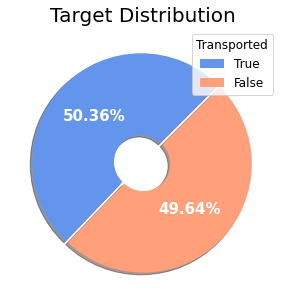

In [19]:
fig, ax = plt.subplots(figsize=(5,5))

labels = train["Transported"].value_counts().index
lst = train["Transported"].value_counts().to_list()
pie = ax.pie(lst, labels = labels, autopct='%.2f%%',
             textprops=dict(color="white", fontsize=15, weight="bold"),
             colors=["cornflowerblue", "lightsalmon"], shadow=True,
             wedgeprops=dict(width=0.75), startangle=45, explode=(0.025,0))

ax.set_title("Target Distribution", size=20)
ax.legend(title="Transported", title_fontsize=12, loc='best', fontsize=12)

plt.show()

In [20]:
train_0 = train[train['Transported']==False]
train_1 = train[train['Transported']==True]

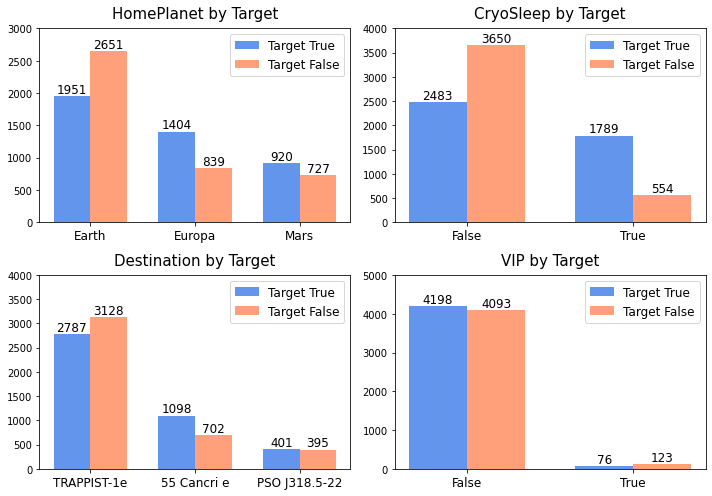

In [21]:
fig, ax = plt.subplots(2,2,figsize=(10,7))

width = 0.35
x = []
b = []
b2 = []

for i in range(2):
    for j in range(2):
        x.append(train_cat.loc[:,col_cat[2*i+j]].value_counts().index)
        b.append(ax[i,j].bar(np.arange(len(x[2*i+j])) - width/2,
                            train_1.loc[:,col_cat[2*i+j]].value_counts().to_list(),
                            width, label = "Target True", color="cornflowerblue"))
        b2.append(ax[i,j].bar(np.arange(len(x[2*i+j])) + width/2,
                            train_0.loc[:,col_cat[2*i+j]].value_counts().to_list(),
                            width, label = "Target False", color="lightsalmon"))
        ax[i,j].bar_label(b[2*i+j], label_type='edge', size=12)
        ax[i,j].bar_label(b2[2*i+j], label_type='edge', size=12)
        ax[i,j].set_title(f'{col_cat[2*i+j]} by Target',
                          pad=10, size=15)
        ax[i,j].set_xticks(np.arange(len(x[2*i+j])), x[2*i+j], size=12)
        ax[i,j].legend(loc="best", fontsize=12)

ax[0,0].set_ylim(0,3000)
ax[0,1].set_ylim(0,4000)
ax[1,0].set_ylim(0,4000)
ax[1,1].set_ylim(0,5000)

fig.tight_layout()
plt.show()

#### Differences in distribution of categorical variables according to target values
**HomePlanet**<br/>
In Earth, False percentage of Tranported is certainly high.<br/>
In Europa, on the contrary, True percentage of Tranported is certainly high.<br/>
In Mars, there is not much difference in Transported.

**CryoSleep**<br/>
If CryoSleep is False, False percentage of Tranported is certainly high.<br/>
When it's True, on the contrary, True percentage of Tranported is about 80%.

**Destination**<br/>
In all cases of Destination, there is not much difference in Transported.

**VIP**<br/>
Whether VIP is False or True, there is not much difference in Transported.

# Step 3. Data Preproccessing
#### - Feature engineering, standardization, one-hot encoding, etc
#### - Create derived variables and descibe why you made this variable.

## Removal of unnecessary variables
- Text features, such as PassengerID, Cabin, and Name, is not necessary in ML model.
- PassengerId will be used in the final submission data.

In [22]:
remove_cols = ['PassengerId', 'Name', 'Cabin']
PassengerId = test['PassengerId']

print("Before Removal")
print("\tTrain data:", train.shape, "/ Test data:", test.shape)
train_data = train.drop(remove_cols, axis=1)
test_data = test.drop(remove_cols, axis=1)

print("After Removal")
print("\tTrain data:", train_data.shape, "/ Test data:", test_data.shape)

Before Removal
	Train data: (8693, 14) / Test data: (4277, 13)
After Removal
	Train data: (8693, 11) / Test data: (4277, 10)


## Imputation of missing value

In [23]:
pd.DataFrame({'train':train_data.isnull().sum(),
              'test':test_data.isnull().sum()}).T

,Age,CryoSleep,Destination,FoodCourt,HomePlanet,RoomService,ShoppingMall,Spa,Transported,VIP,VRDeck
train,179.0,217.0,182.0,183.0,201.0,181.0,208.0,183.0,0.0,203.0,188.0
test,91.0,93.0,92.0,106.0,87.0,82.0,98.0,101.0,NaN,93.0,80.0


In [24]:
# numerical features
imputer_num = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='median')
imputer.fit(train_data[imputer_num])

train_data[imputer_num] = imputer.transform(train_data[imputer_num])
test_data[imputer_num] = imputer.transform(test_data[imputer_num])

In [25]:
# categorical features
imputer_cat = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(train_data[imputer_cat])

train_data[imputer_cat] = imputer.transform(train_data[imputer_cat])
test_data[imputer_cat] = imputer.transform(test_data[imputer_cat])

In [26]:
pd.DataFrame({'train':train_data.isnull().sum(),
              'test':test_data.isnull().sum()}).T

,Age,CryoSleep,Destination,FoodCourt,HomePlanet,RoomService,ShoppingMall,Spa,Transported,VIP,VRDeck
train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


## Numeric Feature Scailing
**Since most numerical variables have an unbalanced distribution, scailing is required.**
- Age does not require scaling.
- Robustscaler is better suited to reduce the impact of extreme values.

In [27]:
rs = RobustScaler()
rs.fit(train_data[col_num[1:]])

train_data[col_num[1:]] = rs.transform(train_data[col_num[1:]])
test_data[col_num[1:]] = rs.transform(test_data[col_num[1:]])

train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.790291,5.366081,7.351377,7.707832,5.746960,7.456545
std,14.341404,16.110221,26.160502,27.182144,21.237029,28.353160
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,79.000000,349.439024,488.737705,1067.818182,422.792453,603.325000


## Categorical Feature Encoding
**Since the machine learning algorithm consists of an equation, string data must be encoded.**

In [28]:
# Target: True -> 1, False -> 0
train_data['Transported'] = train_data['Transported'].map({True: 1, False: 0})

In [29]:
'''
# --- < Ordinal Encoding > ---
ord = OrdinalEncoder()
train_data[col_cat] = ord.fit_transform(train_data[col_cat])
test_data[col_cat] = ord.fit_transform(test_data[col_cat])

train_data.info()
'''

'\n# --- < Ordinal Encoding > ---\nord = OrdinalEncoder()\ntrain_data[col_cat] = ord.fit_transform(train_data[col_cat])\ntest_data[col_cat] = ord.fit_transform(test_data[col_cat])\n\ntrain_data.info()\n'

In [30]:
# --- < One-Hot Encoding > ---
transformer = make_column_transformer(
    (OneHotEncoder(), col_cat), remainder='passthrough')

train_transformed = transformer.fit_transform(train_data[col_cat])
train_transformed_df = pd.DataFrame(train_transformed,
                                    columns=transformer.get_feature_names_out())
train_data = pd.concat([train_data, train_transformed_df], axis = 1)
train_data = train_data.drop(col_cat, axis = 1)

test_transformed = transformer.fit_transform(test_data[col_cat])
test_transformed_df = pd.DataFrame(test_transformed,
                                   columns=transformer.get_feature_names_out())
test_data = pd.concat([test_data, test_transformed_df], axis = 1)
test_data = test_data.drop(col_cat, axis = 1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Age                                       8693 non-null   float64
 1   RoomService                               8693 non-null   float64
 2   FoodCourt                                 8693 non-null   float64
 3   ShoppingMall                              8693 non-null   float64
 4   Spa                                       8693 non-null   float64
 5   VRDeck                                    8693 non-null   float64
 6   Transported                               8693 non-null   int64  
 7   onehotencoder__HomePlanet_Earth           8693 non-null   float64
 8   onehotencoder__HomePlanet_Europa          8693 non-null   float64
 9   onehotencoder__HomePlanet_Mars            8693 non-null   float64
 10  onehotencoder__CryoSleep_False      

In [31]:
'''
# --- < Label Encoding > ---
le = LabelEncoder()
for col in col_cat:
    train_data[col] = train_data[col].astype(str)
    test_data[col] = test_data[col].astype(str)
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] =  le.fit_transform(test_data[col])
train_data = train_data
test_data = test_data
train_data.info()
'''

'\n# --- < Label Encoding > ---\nle = LabelEncoder()\nfor col in col_cat:\n    train_data[col] = train_data[col].astype(str)\n    test_data[col] = test_data[col].astype(str)\n    train_data[col] = le.fit_transform(train_data[col])\n    test_data[col] =  le.fit_transform(test_data[col])\ntrain_data = train_data\ntest_data = test_data\ntrain_data.info()\n'

# Step 4. ML Model

## Data Split
#### Seperate independent and dependent variables.

In [32]:
train_input = train_data[test_data.columns].to_numpy()
train_target = train_data['Transported'].to_numpy()
print(train_input.shape)
print(train_target.shape)

(8693, 16)
(8693,)


#### Split train data and validation data (7:3)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(
    train_input, train_target, test_size=0.3, random_state=42)
print("Train data\t:", X_train.shape, y_train.shape)
print("Validation data\t:", X_val.shape, y_val.shape)

Train data	: (6085, 16) (6085,)
Validation data	: (2608, 16) (2608,)


## LGBM Classifier

In [34]:
lgb = LGBMClassifier(random_state=42)
lgb

LGBMClassifier(random_state=42)

## Hyperparameter tuning
1. Random Search
2. Grid Search

# Step 5. Model Evaluation

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
scores = cross_validate(lgb, X_train, y_train, return_train_score = True, cv=splitter)

print("Train Acc.\t:", np.mean(scores['train_score']))
print("Validation Acc.\t:", np.mean(scores['test_score']))

Train Acc.	: 0.868405916187346
Validation Acc.	: 0.7878389482333608


In [36]:
from sklearn.metrics import accuracy_score

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)
print("Acc.", accuracy_score(y_val, y_pred))

Acc. 0.7891104294478528


# Step 6. Submission
#### - Submit according to the sample given

In [37]:
test_preds = lgb.predict(test_data.to_numpy())
sample_submission['Transported'] = test_preds.astype("bool")
sample_submission.to_csv("submission.csv",index=False)
sample_submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


# Reference
#### - Be sure to link the referenced code in order to prevent plagiarism on your laptop.
#### - Write author name, code title, and url